# Imports

Here we import the requirements to run this notebook. We append the directory above this to `sys.path` so that we can access modules in the main project directory such as `make_dataset`. 

In [1]:
import sys
import re
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict


# Viewing the data

We will load all the data that was downloaded previously and take a look at some of the characteristics of what we have to work with. 

First, we remove data where we don't have annotations for the wine quality (since we can't train from those in a supervised way). We remove duplicate rows:

In [2]:
in_csv = '../data_root/raw/wine_dataset.csv'

In [3]:
df = pd.read_csv(in_csv)
df = df.set_index('Unnamed: 0')
print('Original data:', len(df))
df = df.dropna(subset=['points'])
print('Data where wine quality is available:', len(df))
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print('Final deduplicated dataset:', len(df))

Original data: 10000
Data where wine quality is available: 10000
Final deduplicated dataset: 9942


Looking at the top few rows gives us a glimpse into the structure of the data. This dataset describes quality of wines in terms of points, and has various interesting columns that we can hopefully use to predict the wine quality. 

In [4]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


Using `df.info()` shows us all the column names, and the type of objects they hold.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9942 entries, 0 to 9941
Data columns (total 13 columns):
country                  9936 non-null object
description              9942 non-null object
designation              7129 non-null object
points                   9942 non-null int64
price                    9266 non-null float64
province                 9936 non-null object
region_1                 8289 non-null object
region_2                 3830 non-null object
taster_name              7959 non-null object
taster_twitter_handle    7589 non-null object
title                    9942 non-null object
variety                  9942 non-null object
winery                   9942 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1009.8+ KB


Most of the data fields are non-numeric, but we can get a few statistics over the numeric values. We can see that the `points` range from 80 to 100. From this, we can begin to think on how we can create a machine learning model to predict the points.

In [6]:
df.describe()

,points,price
count,9942.000000,9266.000000
mean,88.459264,35.458990
std,3.034672,40.979322
min,80.000000,5.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,1300.000000


# Understanding the objective

It's always important to understand the data, the objective, and prior work when attacking a new topic. There's actually been a lot of work already done for predicting wine quality, and we want to learn from it as much as possible. For example, we might first think to use some regression techniques, but from doing some basic research, we can find that the points rating given to wines actually reduces into a nice classification scheme:

<img src="wine_ratings.png">

Although the points system may be very granular for a true connosieur, at the end of the day, the points system is useful to the wine consumer, only insofar as they can make a purchasing decision about wines. Converting this to a classification task won't hurt the consumer that much, but we can gain a lot for our models from doing this. Therefore, I will convert the points into quality classes, so we can train a classifier. This may lose some of the granularity of the points system, but I think it will make it easier for the model to learn useful information from the data. The classification system will range from 0 to 5, with 0 being the worst and 5 being the best.

(For future work, it would be instructive to train a regression model as well, and actually compare the results.)

In [7]:
quality_to_class = OrderedDict([
    ('acceptable', 0),
    ('good', 1), 
    ('very good', 2),
    ('excellent', 3),
    ('superb', 4),
    ('classic', 5)
])
    
def points_to_class(points):
    if points <= 82: 
        return list(quality_to_class.values())[0]
    if points <= 86: 
        return list(quality_to_class.values())[1]
    if points <= 89:
        return list(quality_to_class.values())[2]
    if points <= 93: 
        return list(quality_to_class.values())[3]
    if points <= 97: 
        return list(quality_to_class.values())[4]
    if points <= 100: 
        return list(quality_to_class.values())[5]

In [8]:
df['quality'] = df['points'].apply(points_to_class)

Looking at the classes we've created, we can see that the data is pretty unbalanced. There are few wines in the lowest "acceptable" bracket, few in the "superb" bracket, and almost none in the highest quality "classic" bracket. This will make it difficult to train a model to be able to generalize its predictions to the highest bracket. 

In [9]:
value_dict = df['quality'].value_counts().sort_index()
print(value_dict)

0     213
1    2446
2    3506
3    3310
4     456
5      11
Name: quality, dtype: int64


One way of handling this might be to group the highest and second highest brackets into one; however, I would like our prototype to be easily scalable to bigger data, instead having to collapse the points system even further (which would also move us further away from how consumers percieve wine quality). 

Still, I think it will be very hard to train a model on so few examples from the top quality class, so for now, I will roll them into class 4.

In [10]:
quality_to_class = OrderedDict([
    ('acceptable', 0),
    ('good', 1), 
    ('very good', 2),
    ('excellent', 3),
    ('superb', 4),
    ('classic', 4)
])
    
df['quality'] = df['points'].apply(points_to_class)
value_dict = df['quality'].value_counts().sort_index()
print(value_dict)

0     213
1    2446
2    3506
3    3310
4     467
Name: quality, dtype: int64


# Plotting interesting characteristics

We can generate plots in order to understand some more aspects of our data set. 

For example, looking at the price data as a scatter plot, shows us that there are a few outliers, in particular for the "superb" quality wines.

Text(0.5, 1.0, 'Wine quality vs price (zoomed in)')

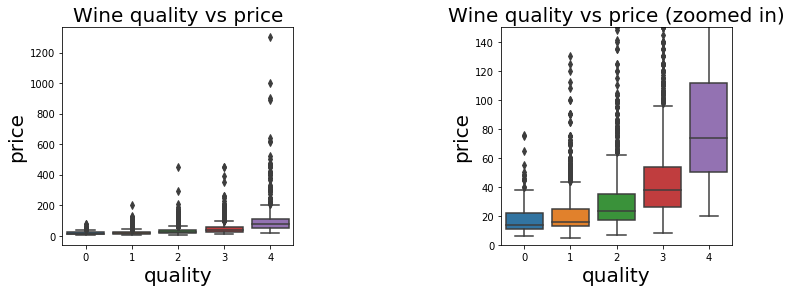

In [11]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.9)

ax_left = axes[0]
ax_right = axes[1]

sns.boxplot(x='quality', y='price', data=df, ax=ax_left)
ax_left.set_xlabel('quality', fontsize=20)
ax_left.set_ylabel('price', fontsize=20)
ax_left.set_title('Wine quality vs price', fontsize=20)

sns.boxplot(x='quality', y='price', data=df, ax=ax_right)
ax_right.set_xlabel('quality', fontsize=20)
ax_right.set_ylabel('price', fontsize=20)
ax_right.set_ylim(0, 150)
ax_right.set_title('Wine quality vs price (zoomed in)', fontsize=20)

Since we're going to be using the text descriptions for training the model, we may be curious as to whether the description length correlates with the wine quality. It seems like better quality wines really do have longer descriptions, on average. Therefore, when we train our model, we will want to consider normalizing over the description length.

Text(0, 0.5, 'description length')

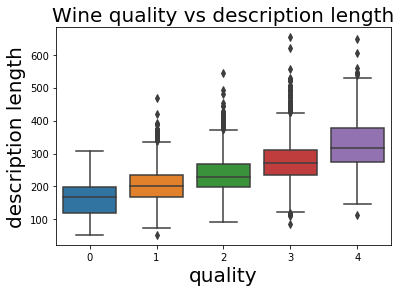

In [12]:
df['description_length'] = df['description'].apply(len)

fig, ax = plt.subplots()
sns.boxplot(x='quality', y='description_length', data=df)
ax.set_title('Wine quality vs description length', fontsize=20) 
ax.set_xlabel('quality', fontsize=20)
ax.set_ylabel('description length', fontsize=20)

If we plot the wine's origin country against the points it received, we can see that the wine's origin also seems to  affect the average quality of the wine, although some countries do have a high variance. 

Text(0.5, 0, 'average points')

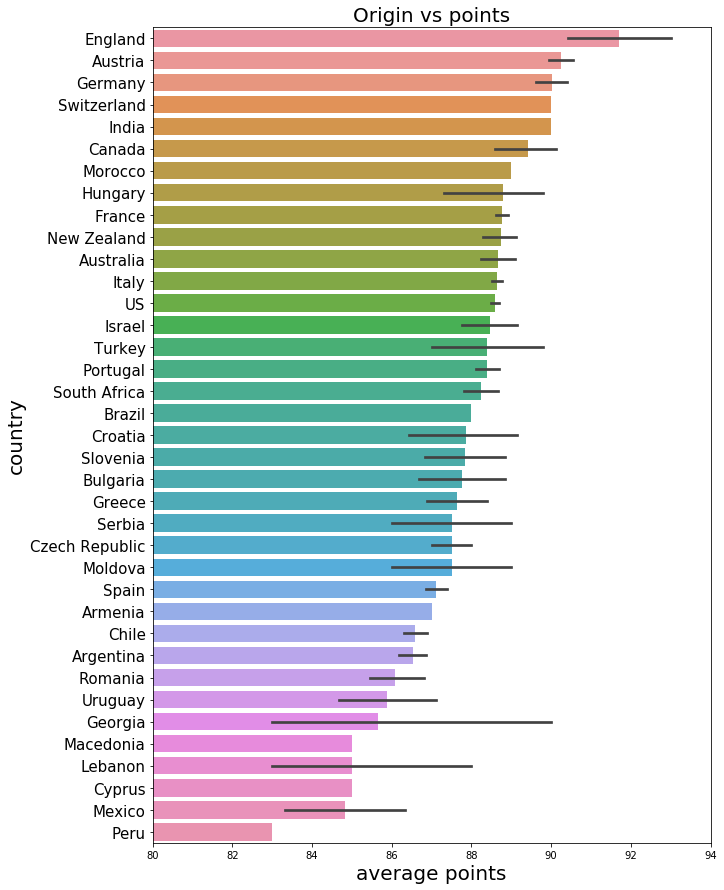

In [13]:
fig, ax = plt.subplots(figsize=(10, 15))

ordered = df.groupby(["country"])['points'].aggregate(np.mean).reset_index().sort_values('points', ascending=0)

ax = sns.barplot(y='country', x='points', data=df, orient="h", order=ordered['country'])
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
ax.set_xlim([80, 94])
ax.set_title('Origin vs points', fontsize=20) 
ax.set_ylabel('country', fontsize=20)
ax.set_xlabel('average points', fontsize=20)

# Splitting the data

We would like to train and test our model on distributions that are representative of the data distribution. Therefore, I will sample from each of the wine qualities separately when creating my train/dev/test sets. I'll use a ratio of approxiately 80%/10%/10% for train/dev/test (respectively).

I have decided to split into a separate dev set instead of using cross-validation, because it will be more useful for training hyperparameters, especially if we follow this pattern once we have access to the customer's bigger data.

In [14]:
dfs_by_quality = {k: v for k, v in df.groupby('quality')}

train_df = pd.DataFrame(columns=df.columns)
dev_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)
for k in dfs_by_quality:
    dfq = dfs_by_quality[k]
    n_samples = len(dfq)
    idx = np.arange(n_samples)
    piece = n_samples // 10
    
    test_idx = idx[0:piece]
    test = df.loc[test_idx]
    test_df = test_df.append(test)

    dev_idx = idx[piece:2*piece]
    dev = df.loc[dev_idx]
    dev_df = dev_df.append(dev)

    train_idx = idx[2*piece:]
    train = df.loc[train_idx]
    train_df = train_df.append(train)

    print('Quality {} train/dev/test: {}, {}, {}'.format(
        k, len(train), len(dev), len(test)))

print('Final train/dev/test sizes: {}, {}, {}'.format(
    len(train_df), len(dev_df), len(test_df)))

Quality 0 train/dev/test: 171, 21, 21
Quality 1 train/dev/test: 1958, 244, 244
Quality 2 train/dev/test: 2806, 350, 350
Quality 3 train/dev/test: 2648, 331, 331
Quality 4 train/dev/test: 375, 46, 46
Final train/dev/test sizes: 7958, 992, 992


The actual data splitting, which saves the files to disk, is handled by the `make_datasets` function but it operates similarly to how I have described above.

# Data preparation

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import label_binarize

We should consider which fields from the dataset will be useful to us when building our model.  We won't use the taster twitter handle since it's not more helpful than having their name. Similarly, the wine designation has more to do with the wine's brand, which I think will be less helpful than knowing the winery the wine comes from plus the grape variety. Finally, I will also ignore the province and country, since they would be highly correlated with the region/variety/winery.

The first easy thing we can do is extract the title from the year, since the title doesn't add much extra information to the review.

In [16]:
def extract_year(title):
    regex = re.compile(r'\d{4}') #find a sequence of 4 digits
    result = re.search(regex, title)
    if result:
        return int(result[0])
    return None

In [17]:
df['year'] = df['title'].apply(extract_year).fillna(-1).astype(int)

One problem in the data is that some values in some columns are missing (`NaN`), which could hurt the model. 

In [18]:
for c in df.columns:
    print('Missing values for {}: {}'.format(c, df[c].isna().sum()))

Missing values for country: 6
Missing values for description: 0
Missing values for designation: 2813
Missing values for points: 0
Missing values for price: 676
Missing values for province: 6
Missing values for region_1: 1653
Missing values for region_2: 6112
Missing values for taster_name: 1983
Missing values for taster_twitter_handle: 2353
Missing values for title: 0
Missing values for variety: 0
Missing values for winery: 0
Missing values for quality: 0
Missing values for description_length: 0
Missing values for year: 0


The price can be fairly easily interpolated by taking the mean of the price for that quality category. 

In [19]:
df["price"] = df.groupby("quality").transform(lambda x: x.fillna(x.median()))['price']

Many of the `region_2` entries are missing, probably because they are not applicable. Instead of trying to find some way of filling in this column, I will actually consider dual-region wines as belonging to a different region class than single-region wines.

In [20]:
df['region'] = df['region_1'].astype(str) + ', ' + df['region_2'].fillna('')

# Text processing

Since we have access to some written reviews, we want to make use of those. Since most classifiers apply a loss function to the model output based on the correct output, they can't accept strings as input, so first we will need to convert the text descriptions to a useable format. One way would be to load pre-trained word embeddings. However, let's start with a simpler method. We could build a bag-of-words model by taking the count of each of the words in the descriptions, however, one big problem with this is that some words (e.g. "wine" and "the") will show up in every review, meaning we won't get much information from them, while other, rarer words will only show up in very specific reviews and our model could overfit to those.

Another common and simple way of modeling a document is using TF-IDF (term frequency-inverse document frequency). This statistic seeks to quantify how much information a particular word provides in the context of a document, in a whole corpus. It creates a vector for each document, representing the words of the document. High values indicates terms that appear often in a given document, but rarely in other documents within the entire corpus. The vector is constructed using the term frequency (the number of times a word from the vocabulary appears in a given document) as a weight for the inverse document frequency (the total number of documents over the number of docments the word appears in). 

The vector can be normalized for document length using the L2 norm. Since we saw in our earlier exploration of the data that document length seems to correlate with wine quality, I would actually like to normalize by document length, because I don't want the model to learn that longer review = better wine.

Before converting the descriptions into tf-idf vectors, we would like to normalize the text by removing casing/punctuation. This is because we want words to be considered the same, whether they start with a capital letter or not, whether they precede punctuation or not, etc., and we don't expect to learn a lot from the tf-idf metric for punctuation. Afterwards, we will split the text on spaces to tokenize it, so we have discrete words that we can convert into the tf-idf vectors.

(Note: this type of text normalization works decently well for English, but does remove some important contextual information, which could cause difficulties in a more ambitious project. Furthermore, other languages may not benefit or may not even require this type of normalization. For example, German uses captial letters to distinguish nouns, so we may want to take advantage of this extra information. Some languages such as Japanese/Mandarin do not explicitly write word boundaries, meaning we would need to create an extra model that predicts word boundaries in the first place. For languages with rich overt morphology such as Russian, it may be beneficial to either lemmatize or to tokenize at the sub-word level, in order to reduce the domain of possible tokens.)

Fortunately, scikit-learn provides us with a nice TfidfVectorizer to do text normalization, tokenization, and normalized tf-idf, so we don't have to code it ourselves (it doesn't lemmatize, so we might consider adding that).

In [21]:
vectorizer = TfidfVectorizer()
doc_vecs = vectorizer.fit_transform(df['description'])
print(doc_vecs.shape) #(documents, vocabulary)

(9942, 11804)


# Feature extraction

Let's combine everything from the previous sections into a single function that we can re-use to extend the data from the train/dev/test datasets:

In [22]:
def extend_wine_data(df):
    """
    Add extra columns to the wine dataset that will help with
    feature extraction.
    """
    df['year'] = df['title'].apply(extract_year)    
    df['region'] = df['region_1'].astype(str) + ', ' + df['region_2'].fillna('')
    df["price"] = df.groupby("quality").transform(lambda x: x.fillna(x.median()))['price']
    
    return df

Next, we will convert our data into features. We'll use the imputer to replace empty values,  then we'll convert categories to one-hot encodings, and we'll normalize continuous variables and ints by removing the median and scaling to unit variance. We'll use the sklearn pipeline to allow us to re-use them for each of the datasets (train/dev/test). 

In [23]:
integer_transformer = Pipeline(steps = [
   ('int_imputer', SimpleImputer(strategy='median', missing_values=np.nan)),
   ('int_scaler', MinMaxScaler())
])

continuous_transformer = Pipeline(steps = [
   ('cont_imputer', SimpleImputer(strategy='median', missing_values=np.nan)),
   ('cont_scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps = [
   ('cat_imputer', SimpleImputer(strategy='constant', fill_value='<unk>', missing_values=np.nan)),
   ('cat_enc', OneHotEncoder(handle_unknown='ignore'))
])

int_cols = ['year']
cont_cols = ['price']
cat_cols = ['taster_name','variety', 'winery', 'region']

preprocessor = ColumnTransformer(transformers=[
    ('ints', integer_transformer, int_cols),
    ('cont', continuous_transformer, cont_cols),
    ('cat', categorical_transformer, cat_cols)
])

We fit our preprocessors on the training data and combine everything into one dataset:

In [24]:
from scipy.sparse import hstack, vstack, csr_matrix

def extract_features_and_classes(df, preprocessor, vectorizer, train=True):
    ys = df['quality'].values.astype(int)
    if train:
        cols = preprocessor.fit_transform(df)
        docs = vectorizer.fit_transform(df['description'])
    else:
        cols = preprocessor.transform(df)
        docs = vectorizer.transform(df['description'])
    
    xs = hstack((docs, cols), format='csr')

    return xs, ys

In [25]:
extended_train_df = extend_wine_data(train_df)
train_xs, train_ys = extract_features_and_classes(extended_train_df, preprocessor, vectorizer)

extended_dev_df = extend_wine_data(dev_df)
dev_xs, dev_ys = extract_features_and_classes(extended_dev_df, preprocessor, vectorizer, train=False)

extended_test_df = extend_wine_data(test_df)
test_xs, test_ys = extract_features_and_classes(extended_test_df, preprocessor, vectorizer, train=False)

#We will use this one for GridSearchCV below (easier to do it here at the start than recombining it later)
extended_train_dev_df = pd.concat([extended_train_df, extended_dev_df])
train_dev_xs, train_dev_ys = extract_features_and_classes(extended_train_dev_df, preprocessor, vectorizer, train=False)

# Models

We now have all of the data converted into a numeric representation, and it's time to choose what type of model to train. 

We may be able to train a model only on the text description, however, I would like to make use of the extra information from the other fields as well. Without doing some testing, it's hard to be sure which model architecture would perform best. It would be a good idea to test a few different models, and possibly even ensemble them together. Another method could be to train a hierarchical model, where the first part will be a text classification model, which uses the text description to predict the classes. The output of this would be fed to the final model to predict the wine quality. 

Below, I will explore a number of different models, including some ensembling methods, and compare their performance.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier,  ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics

In [36]:
lr = ('LR', LogisticRegression(solver='sag', 
                               multi_class='multinomial',
                               max_iter=2000)) 
knn = ('KNN', KNeighborsClassifier()) 
rf = ('RF', RandomForestClassifier(n_estimators=100))
svc = ('SVC', SVC(max_iter=2000, gamma='scale', random_state=42))
gb = ('GB', GradientBoostingClassifier())
et = ('ET', ExtraTreesClassifier(n_estimators=100))
cart = ('CART', DecisionTreeClassifier())
ab = ('AB', AdaBoostClassifier())
lda = ('LDA', LinearDiscriminantAnalysis())
nb = ('NB', GaussianNB())

In [28]:
models = [lr, knn, gb, rf, svc, et, cart, ab, lda, nb]

dev_preds = {}

for name, model in [lr, knn, gb, rf, svc, et, cart, ab]:
    model.fit(train_xs, train_ys)
    preds = model.predict(test_xs)
    dev_preds[name] = preds
    
for name, model in [lda, nb]:
    model.fit(train_xs.toarray(), train_ys)
    preds = model.predict(test_xs.toarray())
    dev_preds[name] = preds

/home/sveta/.conda/envs/datarevenue/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/sveta/.conda/envs/datarevenue/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Below, I will make reports of various metrics for our models' performance (although some failed to converge as the warnings above inform us, and those will, of course, have poor results):

In [38]:
def get_scores(ys, preds, labels):
    report = metrics.classification_report(ys, preds)
    cm = metrics.confusion_matrix(ys, preds, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalize the cm
    return report, cm

def unique_list(seq):
    #to get unique ordered list of labels
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

labels = unique_list(quality_to_class.values())

confusions = {}
reports = {}
    
for name, model in models:
    preds = dev_preds[name]
    report, cm = get_scores(test_ys, preds, labels)
    reports[name] = report
    confusions[name] = cm

Looking at the results of the training on the dev set, we can see that the imbalanced nature of the dataset is hurting us (indeed **the warning above about F-score comes from the imbalanced data**). Since some of our classes have very few data points, it wouldn't be fair to average the model's score across all classes equally, therefore, I find that the weighted average F-score more instructive as a single metric, which weights the F-scores by the number of items in the class. 

In [39]:
for name in reports:
    print('{}.'.format(name))
    print(reports[name])

LR.
              precision    recall  f1-score   support

           0       1.00      0.57      0.72        23
           1       0.85      0.82      0.83       264
           2       0.85      0.90      0.88       339
           3       0.90      0.94      0.92       307
           4       0.91      0.68      0.78        59

    accuracy                           0.87       992
   macro avg       0.90      0.78      0.83       992
weighted avg       0.87      0.87      0.87       992

KNN.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.55      0.45      0.50       264
           2       0.53      0.55      0.54       339
           3       0.60      0.70      0.65       307
           4       0.58      0.47      0.52        59

    accuracy                           0.55       992
   macro avg       0.45      0.44      0.44       992
weighted avg       0.55      0.55      0.55       992

GB.
         

Graphing the confusion matrices shows us at a glance how well each model performed on each class. Good performance is indicated by high values (dark blue) on the diagonal, signifying that the model predicted a target class correctly. 

We can see that some models had difficulty with the low-sample classes. One way to improve performance would be to find more, similar datasets (if the client can't give us more, then we could find near-domain data from other sources to train on), in particular for the low-resource columns (highest/lowest wine qualities).

(Note: Sorry, I'm not sure why the plot cuts off the top/bottom cells in the heatmaps below.)

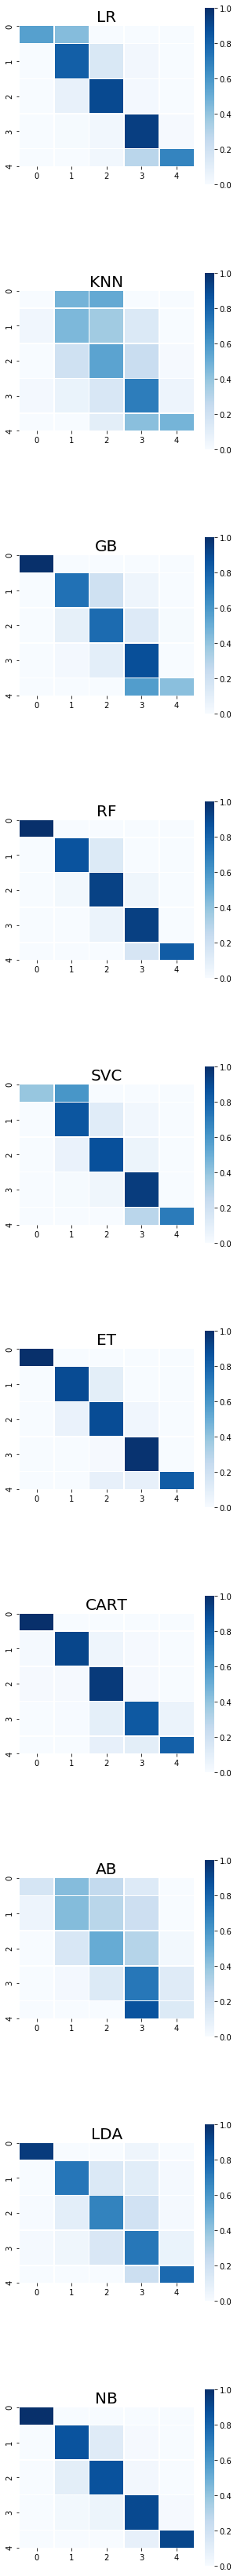

In [40]:
fig, axes = plt.subplots(len(confusions), figsize=(5, 60))
fig.subplots_adjust(hspace=0.5)
for i, name in enumerate(confusions):
    cm = confusions[name]
    ax = axes[i]
    ax.set_title('{}'.format(name), fontsize=20)
    sns.heatmap(cm, ax=ax, cmap='Blues', square=True,
        linewidths=.5, vmin=0, vmax=1.0                   
    )

The tree-based models performed very well; however, it is likely because our dev set comes from a very similar distribution to our training set. Trees don't extrapolate well to unseen data, and it's possible that the larger data from the customer will introduce new points that are farther from our training data.

In particular, if the customer's data includes new wines from brand new produces (such that each of the column values for taster/winery/region/variety is new), the RF will probably perform much worse on the column data, and if the reviewers of the new wines use different language than the reviewers in this data set, the RF will probably perform much worse on the description data also.

Furthermore, some of the models seem to be performing very poorly at first glance, but it may be a case of poorly tuned hyperparameters. SVC, for example, can improve a great deal from hyperparameter tuning. I will use grid search below to autotune SVC. In practice, grid search is usually too time consuming to perform, so a better method might be to use bayesian optimization (e.g. hyperopt package). I will use the dev set to improve the hyperparameters, and keep the test set separate for a final evaluation at the end.


In [42]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

#gamma is the inverse of the radius of influence of the 
#   support vectors; larger gamma = less influence
#C trades off correct classification against maximizing 
#   the margin; larger C = smaller margin 
param_grid = {'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              'kernel':['linear','rbf']}

test_fold = [-1]*train_xs.shape[0]
test_fold.extend([0]*dev_xs.shape[0])

ps = PredefinedSplit(test_fold=test_fold)


clf = GridSearchCV(SVC(random_state=42),
                   param_grid=param_grid,
                   cv=ps)

clf.fit(train_dev_xs, train_dev_ys)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

The reports/graph below shows us that SVC can actually perform very well at this task. We can also look in to see which hyperparameters returned such a good result for us. 

Best params: {'C': 10, 'gamma': 1, 'kernel': 'linear'} 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.94      0.92      0.93       264
           2       0.93      0.96      0.94       339
           3       0.98      0.98      0.98       307
           4       1.00      0.92      0.96        59

    accuracy                           0.95       992
   macro avg       0.97      0.96      0.96       992
weighted avg       0.96      0.95      0.95       992



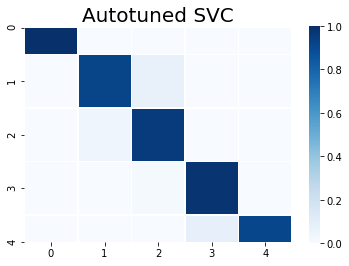

In [46]:
preds = clf.predict(test_xs)
report, cm = get_scores(test_ys, preds, labels)
reports[name] = report
confusions[name] = cm

print('Best params:', clf.best_params_, '\n')

print(report)

fig, ax = plt.subplots()
ax.set_title('{}'.format('Autotuned SVC'), fontsize=20)
sns.heatmap(cm, ax=ax, cmap='Blues', square=True,
    linewidths=.5, vmin=0, vmax=1.0                   
)

Finally, we're not limited to just one viewpoint-- another thing we can try is ensembling different classifiers together. We already used some ensemble models above which use various methods to combine similar architecture models (RandomForest, GradientBoostingClassifier), but below we see how we can combine very different models. 

I will combine Random Forest, which is strong in classification tasks, with SVC, using our best autotuned hyperparameters for SVC. From this, we can see that we get really good performance as well. It doesn't perform as apparently perfectly as the RF on its own, but this ensemble should be better at handling wholly unseen data points. It also doesn't perform better than SVC on its own on this dataset, but I think adding RF should help for when we see points more similar to the ones we've already seen. (Furthermore, we should autotune on this voting classifier instead for the best performance; however, I will skip this now in the interest of training time.)

In [44]:
name = 'RF_SVC'

rf = ('RF', RandomForestClassifier(n_estimators=100)) 
svc = ('SVC', SVC(max_iter=4000, gamma=1, C=10, kernel='linear', random_state=42))

voter = VotingClassifier(estimators=[rf, svc])
voter.fit(train_xs, train_ys)
preds = voter.predict(test_xs)

report, cm = get_scores(test_ys, preds, labels)

/home/sveta/.conda/envs/datarevenue/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


RF_SVC.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.91      0.90      0.90       264
           2       0.84      0.93      0.89       339
           3       0.97      0.90      0.93       307
           4       1.00      0.83      0.91        59

    accuracy                           0.91       992
   macro avg       0.94      0.91      0.93       992
weighted avg       0.91      0.91      0.91       992



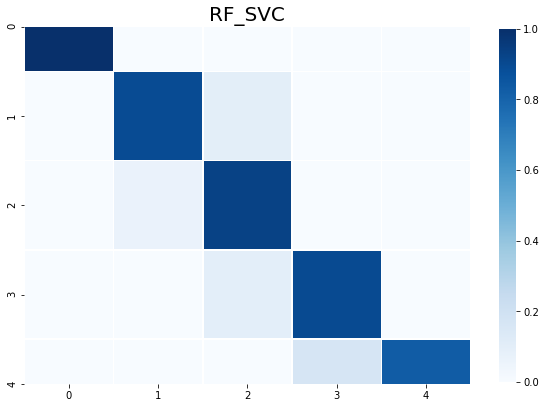

In [45]:
print('{}.'.format(name))
print(report)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('{}'.format(name), fontsize=20)
ax = sns.heatmap(cm, ax=ax, cmap='Blues', square=True,
    linewidths=.5, vmin=0, vmax=1.0, cbar_kws={'shrink': 0.65}            
)

Finally, for dealing with the customer's bigger data, I would ideally like to have a few different models at the ready. Depending on how much time we have for the final training, we may be able to compare their performance on-site, when we have access to larger data, and submit the best models to the customer at that time. Since we already have all of the structure built, it is very easy to plug in different model architectures, and the only cost is some computation time on-site.